# Generate Training Data

This workbook was used by Charles Fox and Chris Van Diemen in the first iteration of the urban green space analysis in 2017 for Dmitry Sivaev, TTL, Tbilisi Urban Renewal Project (GSURR). 

Subsequent versions of the analysis have been performed for other TTLs in the Bank (e.g. Gayatri Singh, Indonesia). These analysis versions were carried out directly by GCW for the task teams, and involved several process improvements. 

It is recommended to contact GCW to carry out this analysis directly. 

Some of the functions used in this notebook can be found in the nice_functions.py file in the Functions folder

In [1]:
!pip freeze > stable-req.txt

Add path to Functions to sys path

In [2]:
import os
import sys
module_path = os.path.abspath(r'C:\Users\charl\Documents\GitHub\GOST_PublicGoods\Implementations\Georgia - Urban Green Space\Functions')
if module_path not in sys.path:
    sys.path.append(module_path)

Import usual suspects + GBDX libs

In [3]:
#import home made functions
import nice_functions as nf
import get_OSM_polygons as getOSM

# import other libraries
import pandas as pd
import numpy as np
from shapely.ops import transform
from shapely.geometry import mapping, Polygon, box, shape
import matplotlib.pyplot as plt
import random
import geopandas as gpd
import fiona
import pickle
from PIL import Image, ImageDraw
import copy

# import special libraries for handling GBDX objects
from gbdxtools import Interface
from gbdxtools.task import env
from gbdxtools import CatalogImage

# initiate GBDX interface object. This can only work if you have a gbdx.config file in your root
gbdx = Interface()

In [4]:
# set some parameters
min_size = .1

In this dictionary, we set up some relations to group like objects. 

Anything we want to identify from OSM as Type 1, Forest green, we tag as 1.

Anything we want as identify from OSM as Type 2, grass, we tag as 2.

Anything we want as identify from OSM as Type 3, Water, we tag as 3.

Anything we want as identify from OSM as Type 4, Building, we tag as 4.

In [5]:
dict_type = {'Forest': 1,'Wood': 1,'Nature Reserve': 1,
             'Grass': 2, 'Farmland': 2, 'Meadow' : 2, 'Fell' : 2, 'Heath' : 2, 'Grassland' : 2, 
             'Water': 3, 'Wetland': 3, 
             'Building': 4, 
             'Theatre': 0, 'Pitch':0}

As these polygons are generate by humans, it is best to assume some degree of digitizing error. Therefore, we bring in the polygon by negatively buffering its perimeter. The value is expressed in metres. 

In [ ]:
buffer_size =  -25

For this analysis we will need the bounding box of the city:

In [ ]:
workspace = r'C:\Users\charl\Documents\GOST\Georgia'
city = 'Tbilisi'
loc = os.path.join(workspace, 'Admin_Boundary',r'Tbilisi_sazrvari.shp')

We project to WGS84 if not already in WGS84

In [ ]:
adminboundary = gpd.read_file(loc)
if adminboundary.crs != {'init' :'epsg:4326'}:
    adminboundary = adminboundary.to_crs({'init' :'epsg:4326'})

Select the right bounding city polygon and load it

In [ ]:
boundpoly = adminboundary.geometry.loc[0]
boundpoly_wkt = str(boundpoly)

convert to a bounding box

In [ ]:
bbox_large_area_float = list(boundpoly.bounds)

Determine correct UTM zone for the city

In [6]:
zone_cal = round((183+bbox_large_area_float[0])/6,0)
EPSG = 32700-round((45+bbox_large_area_float[1])/90,0)*100+round((183+bbox_large_area_float[0])/6,0)
UTM_EPSG_code ='EPSG:%i'  % (EPSG)
print('%s Chosen UTM zone for %s') % (UTM_EPSG_code, city)

EPSG:32638


'Tbilisi'

In this section, we use the custom getOSM function to pull down all of the matching labelled objects in the city bounding box, and add these to a dataframe called 'selection_all':

In [7]:
# Here, we set the sample size for our classes. The first is for forest and grass type objects, the second is for buildings and water.
sample_size = 20
sample_size_b = 50

# labels for each of our classes. 
labels = list(dict_type.keys())

# this dictionary controls the minimum object area for each type of label, measured in Arc Decimal Degrees. 
dict_size = {'forest': 1 , 'grass': .6, 'water': 1, 'building': .8}

geom_list_selection_all = []
selection_all = pd.DataFrame()

# for each label type...
for label in labels: 
    
    #...pull down some examples
    selection, geojson_select, geom_list_selection,UTM_EPSG_code,project_utm,project_wgs = getOSM.get_OSM_polygons(city = city, type_query = label,min_size = dict_size[label], bbox_city = bbox_large_area_float)
    
    # only add 'sample_size' number of examples if label is of type forest or grass
    if label in ['forest','grass']:
        geom_list_selection_all.extend(geom_list_selection[:sample_size])
        selection_all = selection_all.append(selection[:sample_size])
        print('added %s examples for %s' % (len(selection[:sample_size]), label))
    
    # only add 'sample_size_b' number of examples if label is of type building or water
    elif label in ['building','water']:
        geom_list_selection_all.extend(geom_list_selection[:sample_size_b])
        selection_all = selection_all.append(selection[:sample_size_b])
        print('added %s examples for %s' % (len(selection[:sample_size_b]), label))
    
# clean up dataframe of OSM examples
selection_all = selection_all.reset_index().drop('index',axis = 1)
selection_all.item_type.value_counts()

added 20 examples for forest
added 17 examples for grass
added 32 examples for water
added 50 examples for building


Building     50
Water        32
Forest       18
Grass        15
Grassland     2
Wood          2
Name: item_type, dtype: int64

In this section, having pulled down the OSM objects into a dataframe, we iterate through each one.

For each OSM object, we decide whether the corresponding GBDX image pulled is a good one for training data.

Good data is loaded into the data_all numpy array, along with its corresponding labels, expressed as numbers (1 for Forest...)

-----------------------------------------

image for OSM-way-62380275 is good object: 0
2017-09-14T07:59:55.356Z
1030010070409100
Forest


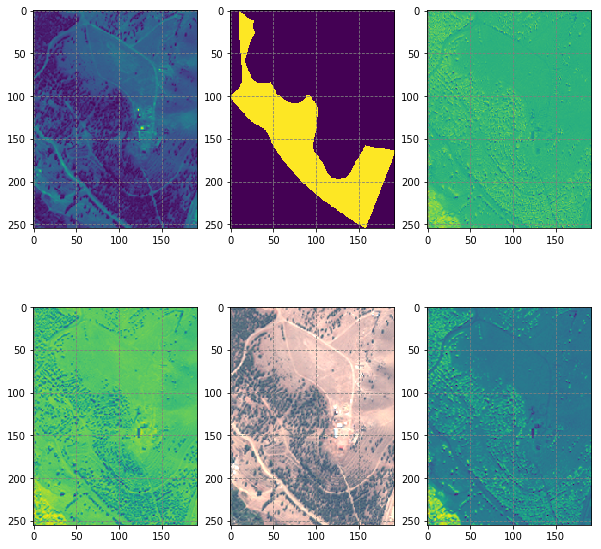

(0L,)
(0L,)
Good Training Data? (y/n) n
training sample rejected
-----------------------------------------

image for OSM-way-61976350 is good object: 1
2016-11-09T08:01:26.047Z
1030010061CF0900
Forest


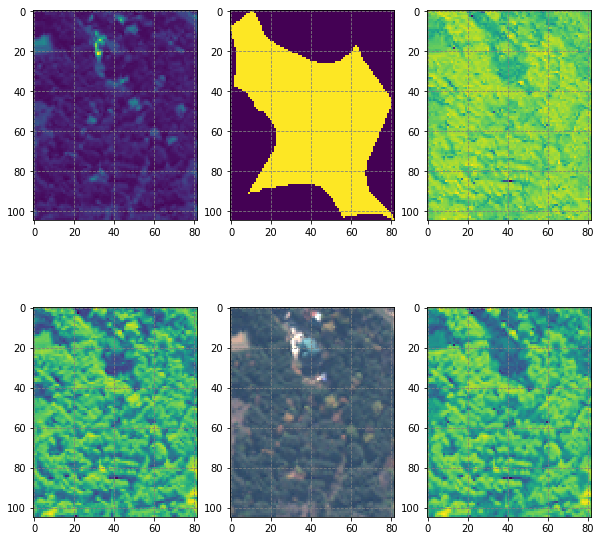

(0L,)
(0L,)
Good Training Data? (y/n) y
-----------------------------------------

no image
-----------------------------------------

Multipolygon - skipping object: 3

-----------------------------------------

image for OSM-way-75659971 is good object: 4
2017-11-13T08:15:21.999Z
1040010035BF7700
Forest


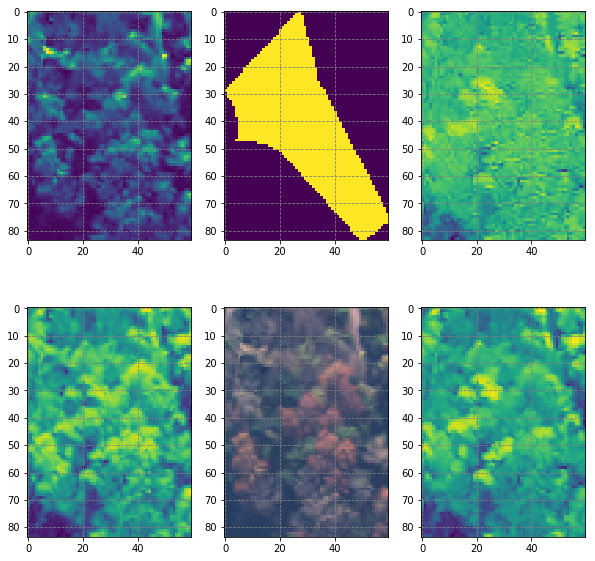

(8610L,)
(8L, 8610L)
Good Training Data? (y/n) y
-----------------------------------------

image for OSM-way-75237277 is good object: 5
2017-09-14T07:59:55.356Z
1030010070409100
Forest


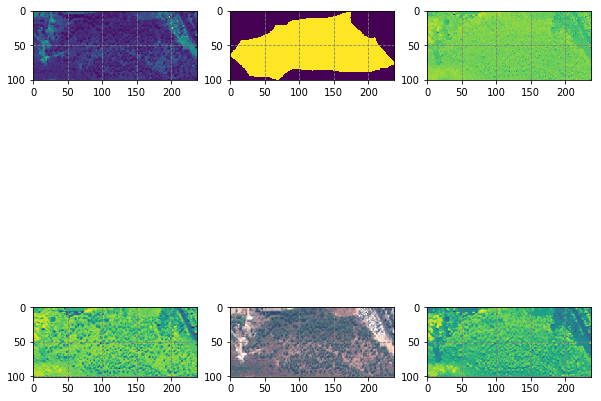

(13650L,)
(8L, 13650L)
Good Training Data? (y/n) y
-----------------------------------------

Multipolygon - skipping object: 6

-----------------------------------------

image for OSM-way-62944139 is good object: 7
2016-05-17T07:55:44.718Z
10300100543AA700
Forest


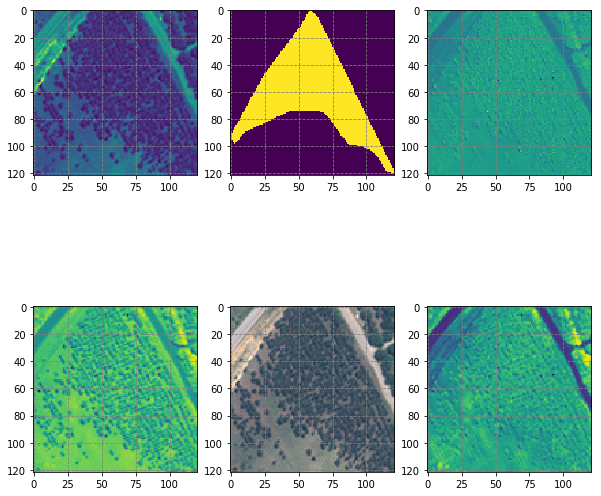

(37688L,)
(8L, 37688L)
Good Training Data? (y/n) y
-----------------------------------------

image for OSM-way-75589821 is good object: 8
2017-09-14T07:59:55.356Z
1030010070409100
Forest


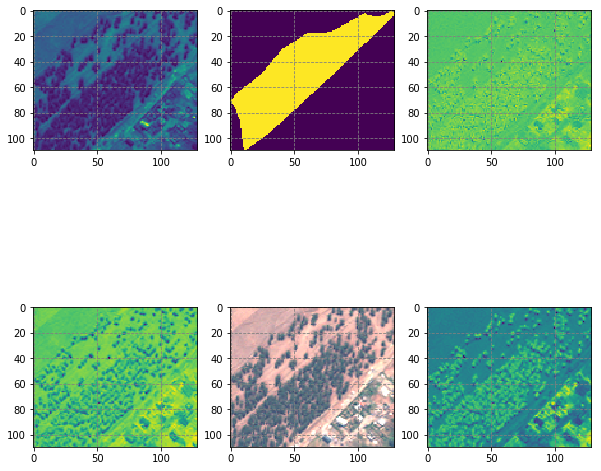

(52450L,)
(8L, 52450L)
Good Training Data? (y/n) n
training sample rejected
-----------------------------------------

image for OSM-way-161062356 is good object: 9
2016-11-09T08:01:26.047Z
1030010061CF0900
Wood


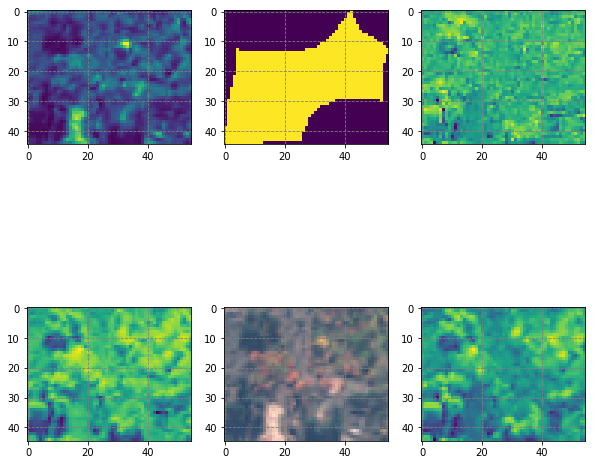

(52450L,)
(8L, 52450L)
Good Training Data? (y/n) n
training sample rejected
-----------------------------------------

Multipolygon - skipping object: 10

-----------------------------------------

image for OSM-way-75610624 is good object: 11
2017-09-14T07:59:55.356Z
1030010070409100
Forest


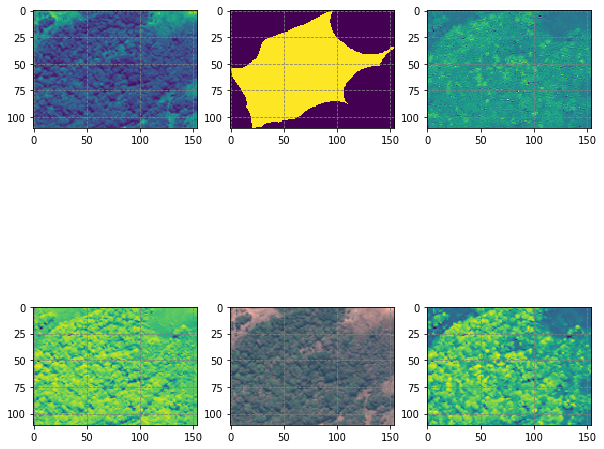

(52450L,)
(8L, 52450L)
Good Training Data? (y/n) y
-----------------------------------------

image for OSM-way-63944022 is good object: 12
2017-09-14T07:59:55.356Z
1030010070409100
Forest


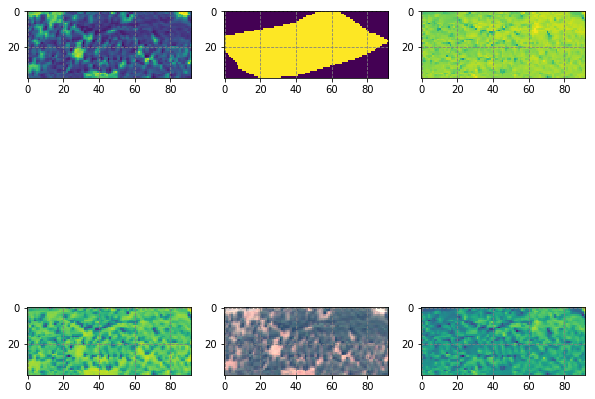

(69544L,)
(8L, 69544L)
Good Training Data? (y/n) y
-----------------------------------------

Multipolygon - skipping object: 13

-----------------------------------------



In [ ]:
# create empty arrays for the training data and label data
label_all = np.array([])
data_all = np.array([])

# iterate through our OSM polygons one at a time:
for objects in selection_all.index:
    
    print '-----------------------------------------\n'
    
    # setting a negatively sized buffer can remove the polygon or make it into a multipolygon.
    # both these types are unusable, so we check to see if this is now the case
    
    # apply projection
    park_utm = transform(project_utm, geom_list_selection_all[objects])  
    
    # get x y coordinates of polygon and set a buffer if polygon is large enough
    if (park_utm.buffer(buffer_size).type != 'Polygon') | (park_utm.buffer(buffer_size).area == 0):
        
        message = "Multipolygon - skipping"
        
        print message + ' object: ' + str(objects) +'\n'
    
    # if a valid polygon:
    else: 
        
        # we buffer by the buffer size to get the object of interest
        obj = park_utm.buffer(buffer_size)
        
        # we pull out the exterior x and y coordinates
        x,y = obj.exterior.xy
        
        # we undo the projection to get the WGS version of the object
        obj_wgs = transform(project_wgs,obj)  

        # get wgs (unprojected) x,y coordinates and create bounding box for image aquisition
        x_wgs,y_wgs = obj_wgs.exterior.xy
        
        bbox_area_float = min(x_wgs), min(y_wgs), max(x_wgs), max(y_wgs)

        bbox_area = str([min(x_wgs), min(y_wgs), max(x_wgs), max(y_wgs)])

        bbox_area_str = nf.listToStringWithoutBrackets(bbox_area)

        # convert bounding box to well known format usable by GBDX tools
        bbox_wkt = box(*bbox_area_float).wkt
        
        # this function, in the nice_functions.py file, actually queries the GBDX backend for acceptable images
        selection_images = nf.image_query_check(bbox_wkt,park_utm,buffer_size,project_wgs,x_wgs,y_wgs)

        # if we find an image...:
        if not selection_images.empty:
            
            # get park bounding box 
            bbox = env.inputs.get('bbox', bbox_area_str)

            # get catalog id from selection
            catalog_id = env.inputs.get('catalog_id', selection_images.id[0])

            # collect image
            try:
                
                # here we try to instantiate a CatalogImage type object from the catalog_id
                image = CatalogImage(catalog_id,      # returned from nf.image_query_check() above
                                     band_type="MS",  # multispectral
                                     bbox=map(float, bbox.split(",")), # we pull down only within this bbox
                                     proj=UTM_EPSG_code,  # crs
                                     pansharpen=False  # we choose not to pansharpen)
                
                
                # we create an array from the GBDX image
                image_array = image[:,:,:].read()

                # get second band to see if image is defective (some images show only black)
                # use image if not defective, otherwise 
                if (image_array.size == 0):

                    print('no image')
                
                # main processing 
                elif (image_array[1,:,:].min() != 0) :

                    
                    print 'image for ' + selection_all.OSM_id[objects] + ' is good object: ' + str(objects )
                    print image.ipe_metadata["image"]["acquisitionDate"]
                    print image.cat_id
                    print selection_all.item_type[objects]

                    # resize polygon and plot polygon over image
                    # subtract minimal values from utm polygon x and y to set 0,0 point as start 
                    x1 = np.subtract(x, min(x))
                    y1 = np.subtract(y, min(y))

                    # divide the x and y coordinate of the polygon by the size of the image to match both sizes 
                    x2 = np.divide(x1,max(x1)/image.shape[2])
                    y2 = np.divide(y1,max(y1)/image.shape[1])
                                     
                    # set key summary stats around image array dimensions
                    n_bands, rows, cols  = image.shape

                    # calculate total cells for each class by masking and setting pixel values to 1

                    # create sequence of edited x and y coordinates, width and heigth  for use in ImageDraw function
                    polygon = [(x2[i], y2[i]) for i in range(len(x2))]
                    width = image.shape[2]
                    height = image.shape[1]

                    # convert polygon coordinates to raster/array values using ImageDraw
                    img = Image.new('L', (width, height), 0)
                    ImageDraw.Draw(img).polygon(polygon, fill=dict_type[selection_all.item_type[objects]])

                    # convert image to array and set as mask
                    mask = np.array(img)

                    # flip the array for matching with the mask array
                    image_array_flipped = np.fliplr(image_array[:,:,:])
                    reshaped_data = image_array_flipped.reshape(8,(rows*cols))
                    reshaped_label = mask.reshape(1,(rows*cols))
                    
                    # here, we set up the data that the user sees. It is a 2 x 3 subplot map. 
                    # we do this to help the user be sure that they are looking at valid data. Each subplot is different. 
                    # the upper central image is the mask of the object, and the lower central object is the RGB image. 
                    # the surrounding plots include NDVI, building index, etc. 
                    f, axarr = plt.subplots(2,3,figsize=(10,10))
                    axarr[0,0].grid(color='gray', linestyle='dashed')
                    axarr[0,0].imshow(((image_array_flipped[2]*image_array_flipped[3]) / (image_array_flipped[1]*1000)))
                    axarr[0,1].grid(color='gray', linestyle='dashed')
                    axarr[0,1].imshow(mask)
                    axarr[0,2].grid(color='gray', linestyle='dashed')
                    axarr[0,2].imshow(((image_array_flipped[6] - image_array_flipped[5]) / (image_array_flipped[6] + image_array_flipped[5])))
                    axarr[1,0].grid(color='gray', linestyle='dashed')
                    axarr[1,0].imshow(((image_array_flipped[7] - image_array_flipped[0]) / (image_array_flipped[7] + image_array_flipped[0])))
                    axarr[1,1].grid(color='gray', linestyle='dashed')
                    axarr[1,1].imshow(np.dstack([image_array_flipped[4],image_array_flipped[2],image_array_flipped[1]])/2000)
                    axarr[1,2].grid(color='gray', linestyle='dashed')
                    axarr[1,2].imshow(((image_array_flipped[6] - image_array_flipped[4]) / (image_array_flipped[6] + image_array_flipped[1])))
                    plt.show()
                                        
                    #ask user if this is good data. If y entered, we keep the data, otherwise, we discard. 
                    decision = raw_input("Good Training Data? (y/n) ")

                    if decision == 'y':

                        # check if this is the first iteration, if so add the first data set otherwise:
                        # append the new image data to the other data
                        if data_all.size == 0:

                            data_all = reshaped_data 

                        else: 

                            data_all = np.concatenate((data_all,reshaped_data), axis = 1)

                        label_all = np.append(label_all,reshaped_label)

                    elif decision == 'n':

                        print 'training sample rejected'

                        pass
            except:
                                     
                print 'image defective' 
                # move to next without doing analysis
                pass

        else:

            print 'no image' 
            # move to next without doing analysis      
            
### Remove pixels without class data
label_all_no0 = label_all[label_all != 0]
data_all_no0 = data_all[:,label_all != 0]

Once the user has completed the above data review process for every entry, we pickle the selections and save them to drive: 

In [ ]:
pick = r'C:\Users\charl\Documents\GOST\Georgia\pickle'

with open(os.path.join(pick, 'selection_objects_all_{}.pickle'.format(city)), 'wb') as handle:
    pickle.dump(selection_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(os.path.join(pick, 'geom_list_selection_all{}.pickle'.format(city)), 'wb') as handle:
    pickle.dump(geom_list_selection_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(os.path.join(pick, 'project_utm_{}.pickle'.format(city)), 'wb') as handle:
    pickle.dump(project_utm, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(os.path.join(pick, 'project_wgs_{}.pickle'.format(city)), 'wb') as handle:
    pickle.dump(project_wgs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(os.path.join(pick, 'UTM_EPSG_code_{}.pickle'.format(city)), 'wb') as handle:
    pickle.dump(UTM_EPSG_code, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(os.path.join(pick, 'label_all_{}.pickle'.format(city)), 'wb') as handle:
    pickle.dump(label_all_no0, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(os.path.join(pick, 'data_all_{}.pickle'.format(city)), 'wb') as handle:
    pickle.dump(data_all_no0, handle, protocol=pickle.HIGHEST_PROTOCOL)

At this point, the training data generation has been completed. 

The remainder of the script shows some experimental work done to use AutoML as the predictive engine of this process. 

### Prediction Step 1: Prepare DataSet

In [ ]:
# These were the imported classes used for the sklearn verion; these are not required for the AutoML version but are left here for reference
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from osgeo import gdal
from sklearn import metrics

# A list of "random" colors (for a nicer output)
COLORS = ["#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941"]

# import data from above (saved training data, pickled)
pick = r'C:\Users\charl\Documents\GOST\Georgia\pickle'

with open(os.path.join(pick, 'data_all_{}.pickle'.format(city)), 'rb') as handle:
    data_all = pickle.load(handle)
    
with open(os.path.join(pick, 'label_all_{}.pickle'.format(city)), 'rb') as handle:
    label_all = pickle.load(handle)

# make a data dataframe, add labels
data = pd.DataFrame(data_all.T)
data['class'] = label_all
data['class'] = data['class'].astype('category')


# 8-band (0:Coastal, 1:Blue, 2:Green, 3:Yellow, 4:Red, 5:Red-edge, 6:NIR1, 7:NIR2) Multispectral

# Calculate NDVI

# ndvi = (nir - red)/(nir + red)
data['ndvi'] = (data[6] - data[4])/(data[6] + data[4])

# water index
data['water_index'] = (data[7] - data[0]) / (data[7] + data[0])

# Buildings index 1
data['NDBI'] = (data[6] - data[5])/(data[6] + data[5]) 

# Buildings index 2
data['NDBI2'] = (data[7] - data[5])/(data[7] + data[5]) 

# iron index
data['iron'] = (data[2]*data[3]) / (data[1]*1000)

#data['EVI'] = 2.5 * (data[6] - data[4]) / (data[6] + 6.5 * data[4] - 7.5 * data[1] + 1 )

# randomize index
data = data.sample(frac=1).reset_index(drop=True)

y = data['class']

data.columns = ['0', '1', '2', '3', '4', '5', '6', '7','class','ndvi', 'water_index', 'NDBI', 'NDBI2', 'iron']

now that the dataframe is set up with the 8 bands, the class of the pixel, and the extra spectral indices, we can split out the training data. Here, we take 2/3rds of the data to work with:

In [ ]:
traindf = data[:((len(data)/3)*2)]

In [ ]:
X = data.drop('class', axis = 1)

### AutoML

We set up the H2O environment and H20Frame objects required for the ML

In [ ]:
import h2o
from h2o.automl import H2OAutoML
from h2o.frame import H2OFrame

# initiate an h2o session
h2o.init()

# create an H2o frame of the training data
train2o = H2OFrame(python_obj = traindf)

# remove the dependent variable, class, from the dataframe
x = train2o.columns
y = "class"
x.remove(y)

# Here we train several models with a maximum runtime of 600 seconds. This can be flexed up if you have lots of time
aml = H2OAutoML(max_runtime_secs = 600)
aml.train(x = x, y = y,
          training_frame = train2o)

In [ ]:
# the leaderboard prints all of the performance metrics of the trained models

In [ ]:
aml.leaderboard

### Testing the Trained model
In this section, we reload in an image, and apply the prediction algorithm to it to see if we got good land cover results. The first step is to grab an image. Here, we know a Catalog ID we want to test:

In [ ]:
bbox = gpd.read_file(r'C:\Users\charl\Documents\GOST\Georgia\Admin_Boundary\bbox_test.shp')
bbox = bbox.to_crs({'init' :'epsg:4326'})
bbox = bbox.geometry.loc[0]
bbox = str(bbox.bounds).replace('(',"").replace(')',"")
UTM_EPSG_code = 'EPSG:32638'
catalog_id = '1030010061CF0900'
image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")),
                                 proj=UTM_EPSG_code,pansharpen=False)
image_array = image.read()

The array we apply the prediction model to needs to have precisely the same dimensions as the training data - which means re-creating the various indices for this specific image. We do this below:

In [ ]:
n_bands, rows, cols = image_array.shape

n_samples = rows*cols
  
h = image_array.shape[1]
w = image_array.shape[2]

zeroes = np.zeros((5,h,w))

data = np.vstack((image_array, zeroes))

data[8,:,:] = (data[6] - data[4])/(data[6] + data[4])

data[9,:,:] = (data[7] - data[0]) / (data[7] + data[0])

data[10,:,:] = (data[6] - data[5])/(data[6] + data[5]) 

data[11,:,:] = (data[7] - data[5])/(data[7] + data[5]) 

data[12,:,:] = (data[2]*data[3]) / (data[1]*1000)

# image_array_flipped = np.fliplr(image_array[:,:,:])
reshaped_data = data.reshape(13,(rows*cols))

We are using H20 as our prediction model here, so we need a function that takes a numpy array (the raw image format), loads it into an H20Frame, applies a prediction, and then returns the results:

In [ ]:
def AMLpred(image):
    df = pd.DataFrame(image)
    df.columns = ['0', '1', '2', '3', '4', '5', '6', '7','ndvi', 'water_index', 'NDBI', 'NDBI2', 'iron']
    X_test = H2OFrame(python_obj = df)
    y_pred = aml.predict(X_test)
    y_pred = y_pred.as_data_frame(use_pandas=True)
    y_pred = y_pred.values
    return y_pred

We apply this prediction function to the image:

In [ ]:
result = AMLpred(reshaped_data.T)
classification = result.T.T.T.reshape((rows, cols))
classification2 = classification.round(0)

Now, we plot this classification numpy array as an image using matplotlib, alongside the RGB stacked array:

In [ ]:
# dict_type = {'Forest': 1,'Wood': 1,'Nature Reserve': 1,'Wetland': 1, 'Grass': 2, 'Water': 3, 'Building': 4}

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import pyplot as plt

f = plt.figure( figsize = (20,20))
f.add_subplot(1, 2,1)

# pick out the RGB layers of the image
r = image_array[3,:,:]
g = image_array[2,:,:]
b = image_array[1,:,:]
rgb = np.dstack([r,g,b])
f.add_subplot(1, 2, 1)
plt.imshow(rgb/3000)
f.add_subplot(1, 2, 2)

im = plt.imshow(classification2,cmap='jet')

plt.colorbar(im,fraction=0.046, pad=0.04)

### Save Down
Write trained classifier to pickle


In [ ]:
with open(os.path.join(pick,'trained_classifier_{}.pickle'.format(city)), 'wb') as handle:
    pickle.dump(gs, handle, protocol=pickle.HIGHEST_PROTOCOL)